In [88]:
import re
import numpy as np
import matplotlib.pyplot as plt
import baltic as bt

class BalticTreePlotter:
    def __init__(self, tree_path, reference_time=None,
                 target_span=1000.0, scale='linear',
                 knee_frac=0.95, gamma=0.95, softlog_c=2.0,
                 highlight_pattern=r'(SNVT|MIPE|PESO)', label_push_frac=0.02):
        self.tree_path = tree_path
        self.ref_time = reference_time
        self.TARGET_SPAN = float(target_span)
        self.scale = scale  # 'linear'|'piecewise'|'softlog'|'none'
        self.KNEE_FRAC = float(knee_frac)
        self.GAMMA = float(gamma)
        self.SOFTLOG_C = float(softlog_c)
        self.highlight_re = re.compile(highlight_pattern, re.I)
        self.rx_mipe_peso = re.compile(r'(?:^|[^A-Z0-9])(MIPE|PESO)[-_ ]?(\d+)', re.I)
        self.label_push_frac = float(label_push_frac)
        self.whitman_color = "#19798b"
        self.ll = None
        self.snvt_tips = []
        self.snvt_clade_nodes = set()
        self.tmin = None
        self.tmax = None
        self.span = None

    def load(self):
        self.ll = bt.loadNexus(self.tree_path, absoluteTime=False)
        if self.ref_time is not None:
            self.ll.setAbsoluteTime(self.ref_time)
        return self

    @staticmethod
    def _get_time(n):
        t = getattr(n, 'absoluteTime', None)
        if t is None: t = getattr(n, 'x', None)
        if t is None: t = getattr(n, 'numdate', None)
        if t is None and getattr(n, 'parent', None) is not None:
            return BalticTreePlotter._get_time(n.parent)
        return float(t) if t is not None else 0.0

    def _fit_time_scale(self):
        tips = [n for n in self.ll.Objects if n.is_leaf()]
        t_tip = np.array([self._get_time(n) for n in tips], dtype=float)
        self.tmin, self.tmax = float(np.min(t_tip)), float(np.max(t_tip))
        self.span = max(self.tmax - self.tmin, 1e-9)

    def _x_linear(self, n):
        return ((self._get_time(n) - self.tmin) / self.span) * self.TARGET_SPAN

    def _x_piecewise(self, n):
        s = (self._get_time(n) - self.tmin) / self.span
        s = 0.0 if s < 0 else (1.0 if s > 1 else s)
        if s >= self.KNEE_FRAC: out = s
        else: out = (s / self.KNEE_FRAC) ** self.GAMMA * self.KNEE_FRAC
        return out * self.TARGET_SPAN

    def _x_softlog(self, n):
        s = (self._get_time(n) - self.tmin) / self.span
        s = 0.0 if s < 0 else (1.0 if s > 1 else s)
        return (np.log1p(self.SOFTLOG_C*s) / np.log1p(self.SOFTLOG_C)) * self.TARGET_SPAN

    def x_fn(self, n):
        if self.scale == 'linear':   return self._x_linear(n)
        if self.scale == 'piecewise':return self._x_piecewise(n)
        if self.scale == 'softlog':  return self._x_softlog(n)
        return self._get_time(n)

    @staticmethod
    def _tokens(name):
        s = re.sub(r'[^A-Za-z0-9]+', '_', str(name).upper())
        return [t for t in s.split('_') if t]

    def _is_snvt_like(self, name):
        if not name: return False
        u = str(name).upper()
        if self.highlight_re.search(u): return True
        return self.rx_mipe_peso.search(u) is not None

    @staticmethod
    def _collect_descendants(node, all_nodes):
        kids = [x for x in all_nodes if x.parent is node]
        out = []
        for c in kids:
            out.append(c)
            out.extend(BalticTreePlotter._collect_descendants(c, all_nodes))
        return out
    
    # accession at start of the name, optionally quoted: e.g. 'OQ999159.1 |...'
    _ACC_RE = re.compile(r"""^['"]?([A-Z]{1,2}\d{5,}\.\d)""", re.I)

    def _accession(self, name: str):
        if not name:
            return None
        m = self._ACC_RE.match(str(name).strip())
        return m.group(1) if m else None

    def _tip_label(self, tip):
        nm = (getattr(tip, 'name', '') or '')
        up = nm.upper()

        # --- Case 1: Whitman-style names (SNVT/MIPE/PESO) ---
        m = re.search(r'_SNVT_([A-Z]+)_(\d+)(?:_FILLED)?', up)
        if m:
            prefix, num = m.group(1), int(m.group(2))
            if prefix == 'PEMA': prefix = 'PESO'
            if prefix == 'MIPE': prefix = 'MIMO'
            return f"SNV/{prefix}{num}"

        # --- Case 2: Accessioned NCBI names ---
        acc = self._accession(nm)
        if acc:
            return f"SNV/Isolate {acc}"

        # --- Case 3: Anything else ---
        m2 = re.search(r'(MIPE|PESO)[-_ ]?(\d+)', up)
        if m2:
            prefix, num = m2.group(1).upper(), int(m2.group(2))
            if prefix == 'PEMA': prefix = 'PESO'
            if prefix == 'MIPE': prefix = 'MIMO'
            return f"SNV/{prefix}{num}"

        iso = tip.traits.get('isolate') if hasattr(tip, 'traits') else None
        if iso:
            return f"SNV/Isolate {iso}"
        first = up.split(' ', 1)[0].split('|', 1)[0]
        return f"SNV/{first}" if first else "SNV/UNKNOWN"

    def _assign_isolate(self):
        p1 = re.compile(r'isolate\s+([A-Za-z0-9-*]+)', re.I)
        p2 = re.compile(r'strain\s+([A-Za-z0-9-]+)',  re.I)
        for k in self.ll.Objects:
            if not k.is_leaf(): continue
            nm = getattr(k, 'name', '') or ''
            m = p1.search(nm) or p2.search(nm)
            k.traits['isolate'] = (m.group(1) if m else nm.split(' ',1)[0].split('|',1)[0])

    def find_highlight_clade(self):
        self.snvt_tips = [n for n in self.ll.Objects if n.is_leaf() and self._is_snvt_like(getattr(n,'name',''))]
        if not self.snvt_tips:
            self.snvt_clade_nodes = set()
            return
        mrca = self.ll.commonAncestor(self.snvt_tips)
        self.snvt_clade_nodes = {mrca, *self._collect_descendants(mrca, self.ll.Objects)}

    def plot(self, figsize=(10,10), abs_xlim=None, scaled_xlim=None, save=None, dpi=300):
        if self.ll is None: self.load()
        self._fit_time_scale()
        self.find_highlight_clade()
        self._assign_isolate()

        colour_func = lambda n: self.whitman_color if n in self.snvt_clade_nodes else 'gray'
        width_func  = lambda n: 2.5 if n in self.snvt_clade_nodes else 1.0

        fig, ax = plt.subplots(figsize=figsize, facecolor='w')
        self.ll.plotTree(ax, colour=colour_func, width=width_func,
                        x_attr=lambda n: self.x_fn(n), y_attr=lambda n: n.y)


        def _to_scaled(t_abs):
            if self.scale == 'none':
                return float(t_abs)
            s = (float(t_abs) - self.tmin) / self.span
            return max(0.0, min(1.0, s)) * self.TARGET_SPAN

        if scaled_xlim is not None:
            ax.set_xlim(*scaled_xlim)
        elif abs_xlim is not None:
            ax.set_xlim(_to_scaled(abs_xlim[0]), _to_scaled(abs_xlim[1]))
        else:
            ax.set_xlim((0, self.TARGET_SPAN) if self.scale != 'none' else (self.tmin, self.tmax))

        ax.set_ylim(-1, self.ll.ySpan + 1)

        # label offset (fraction of span)
        x0, x1 = ax.get_xlim()
        xspan = max(x1 - x0, 1e-9)
        push_abs = self.label_push_frac * xspan   # e.g., 0.05 pushes by 5% of visible width

        for tip in (n for n in self.ll.Objects if n.is_leaf()):
            marked  = (tip in self.snvt_clade_nodes)
            tip_x   = self.x_fn(tip)
            label_x = tip_x + push_abs
            ax.plot(tip_x, tip.y, 'o',
                    color=(self.whitman_color if marked else 'gray'),
                    markersize=(6 if marked else 3))
            ax.plot([tip_x, label_x], [tip.y, tip.y],
                    linestyle='--', color='gray', linewidth=0.5)
            ax.text(label_x, tip.y, self._tip_label(tip),
                    fontsize=6, color=(self.whitman_color if marked else 'k'),
                    va='center', clip_on=False)
        for loc in ['top','right','left','bottom']: ax.spines[loc].set_visible(False)
        ax.set_yticklabels([]); ax.set_xticklabels([])
        ax.tick_params(axis='both', which='both', length=0)

        # axis limits:
        def _to_scaled(t_abs):
            if self.scale == 'none':    # raw absolute coordinates
                return t_abs
            # linear normalization of absolute year to [0, TARGET_SPAN]
            s = (float(t_abs) - self.tmin) / self.span
            return max(0.0, min(1.0, s)) * self.TARGET_SPAN

        if scaled_xlim is not None:
            ax.set_xlim(*scaled_xlim)
        elif abs_xlim is not None:
            ax.set_xlim(_to_scaled(abs_xlim[0]), _to_scaled(abs_xlim[1]))
        else:
            ax.set_xlim((0, self.TARGET_SPAN) if self.scale!='none' else (self.tmin, self.tmax))

        ax.set_ylim(-1, self.ll.ySpan + 1)
        if save:
            plt.savefig(save, dpi=dpi, bbox_inches='tight')
        plt.show()



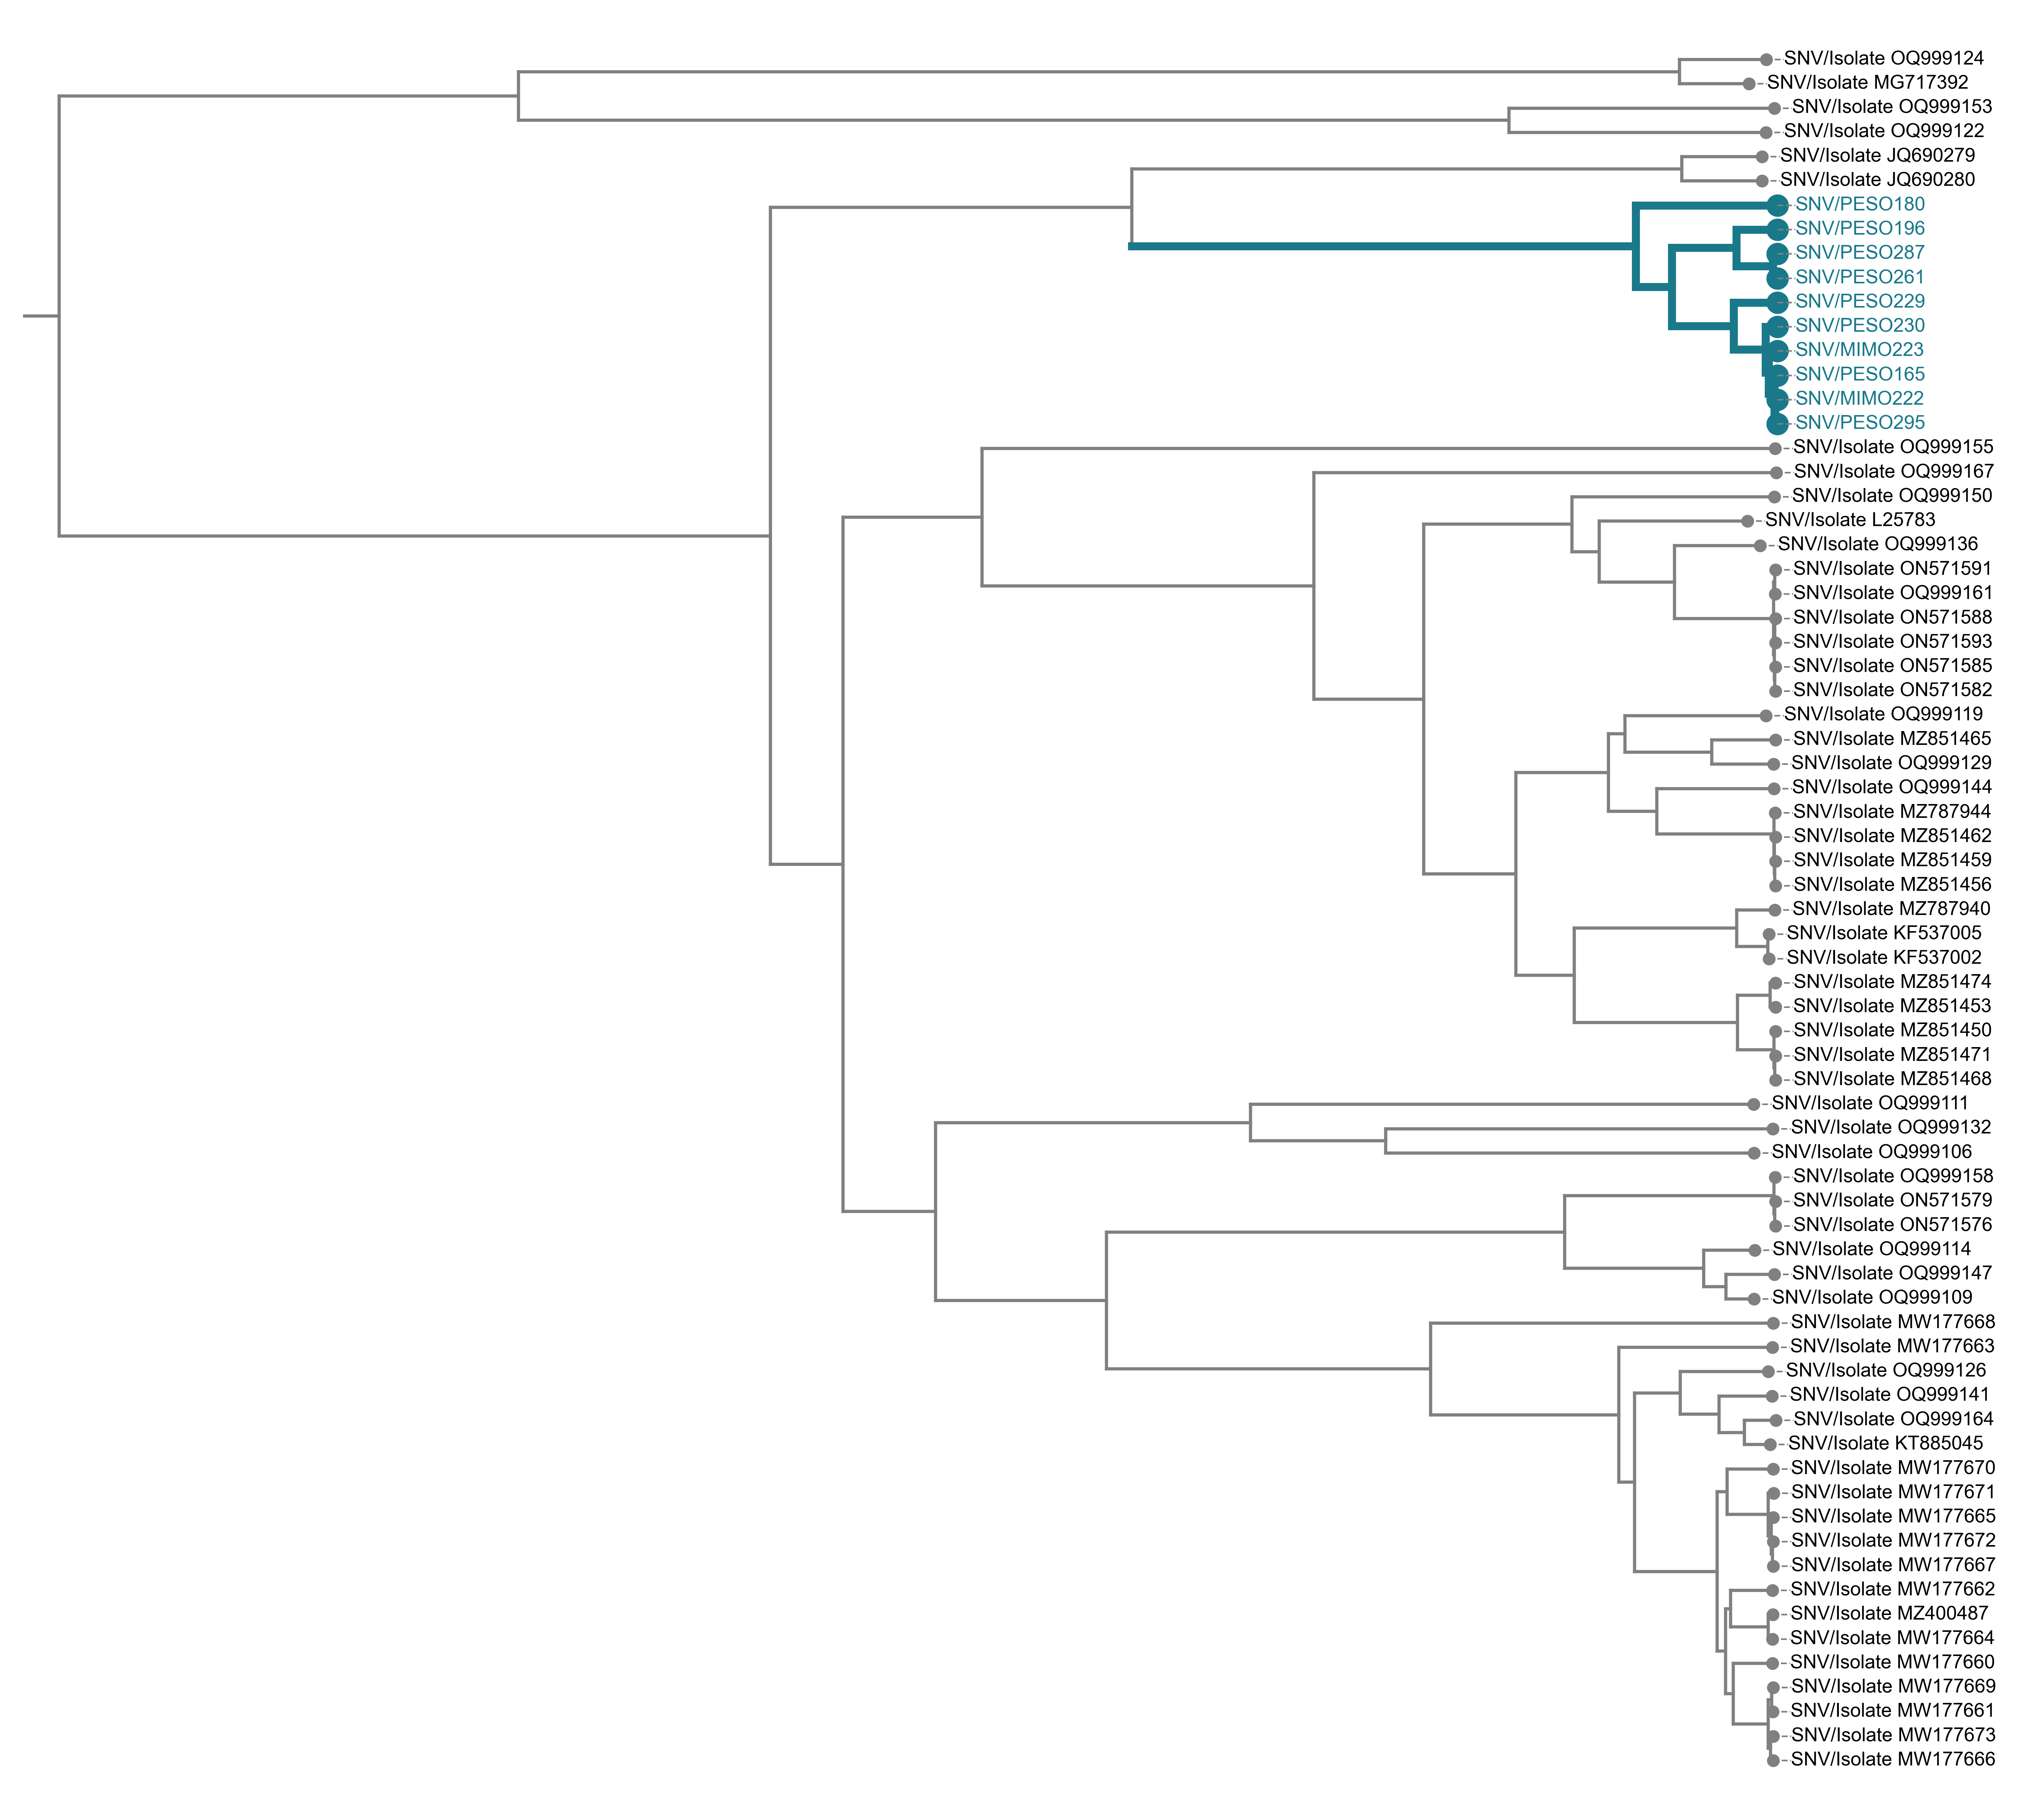

In [82]:
plotter = BalticTreePlotter('../Trees/SNV_M_NCBI_MEZAP2.aligned.mcc.tree',
                            reference_time=2025.25,
                            target_span=1000, scale='linear', label_push_frac=0.01)
plotter.plot(scaled_xlim=(-57000, 2035),
             save="../Figures/SNVT_M.jpeg",
             dpi=600)# or plot(x_lower=0, x_upper=1000)

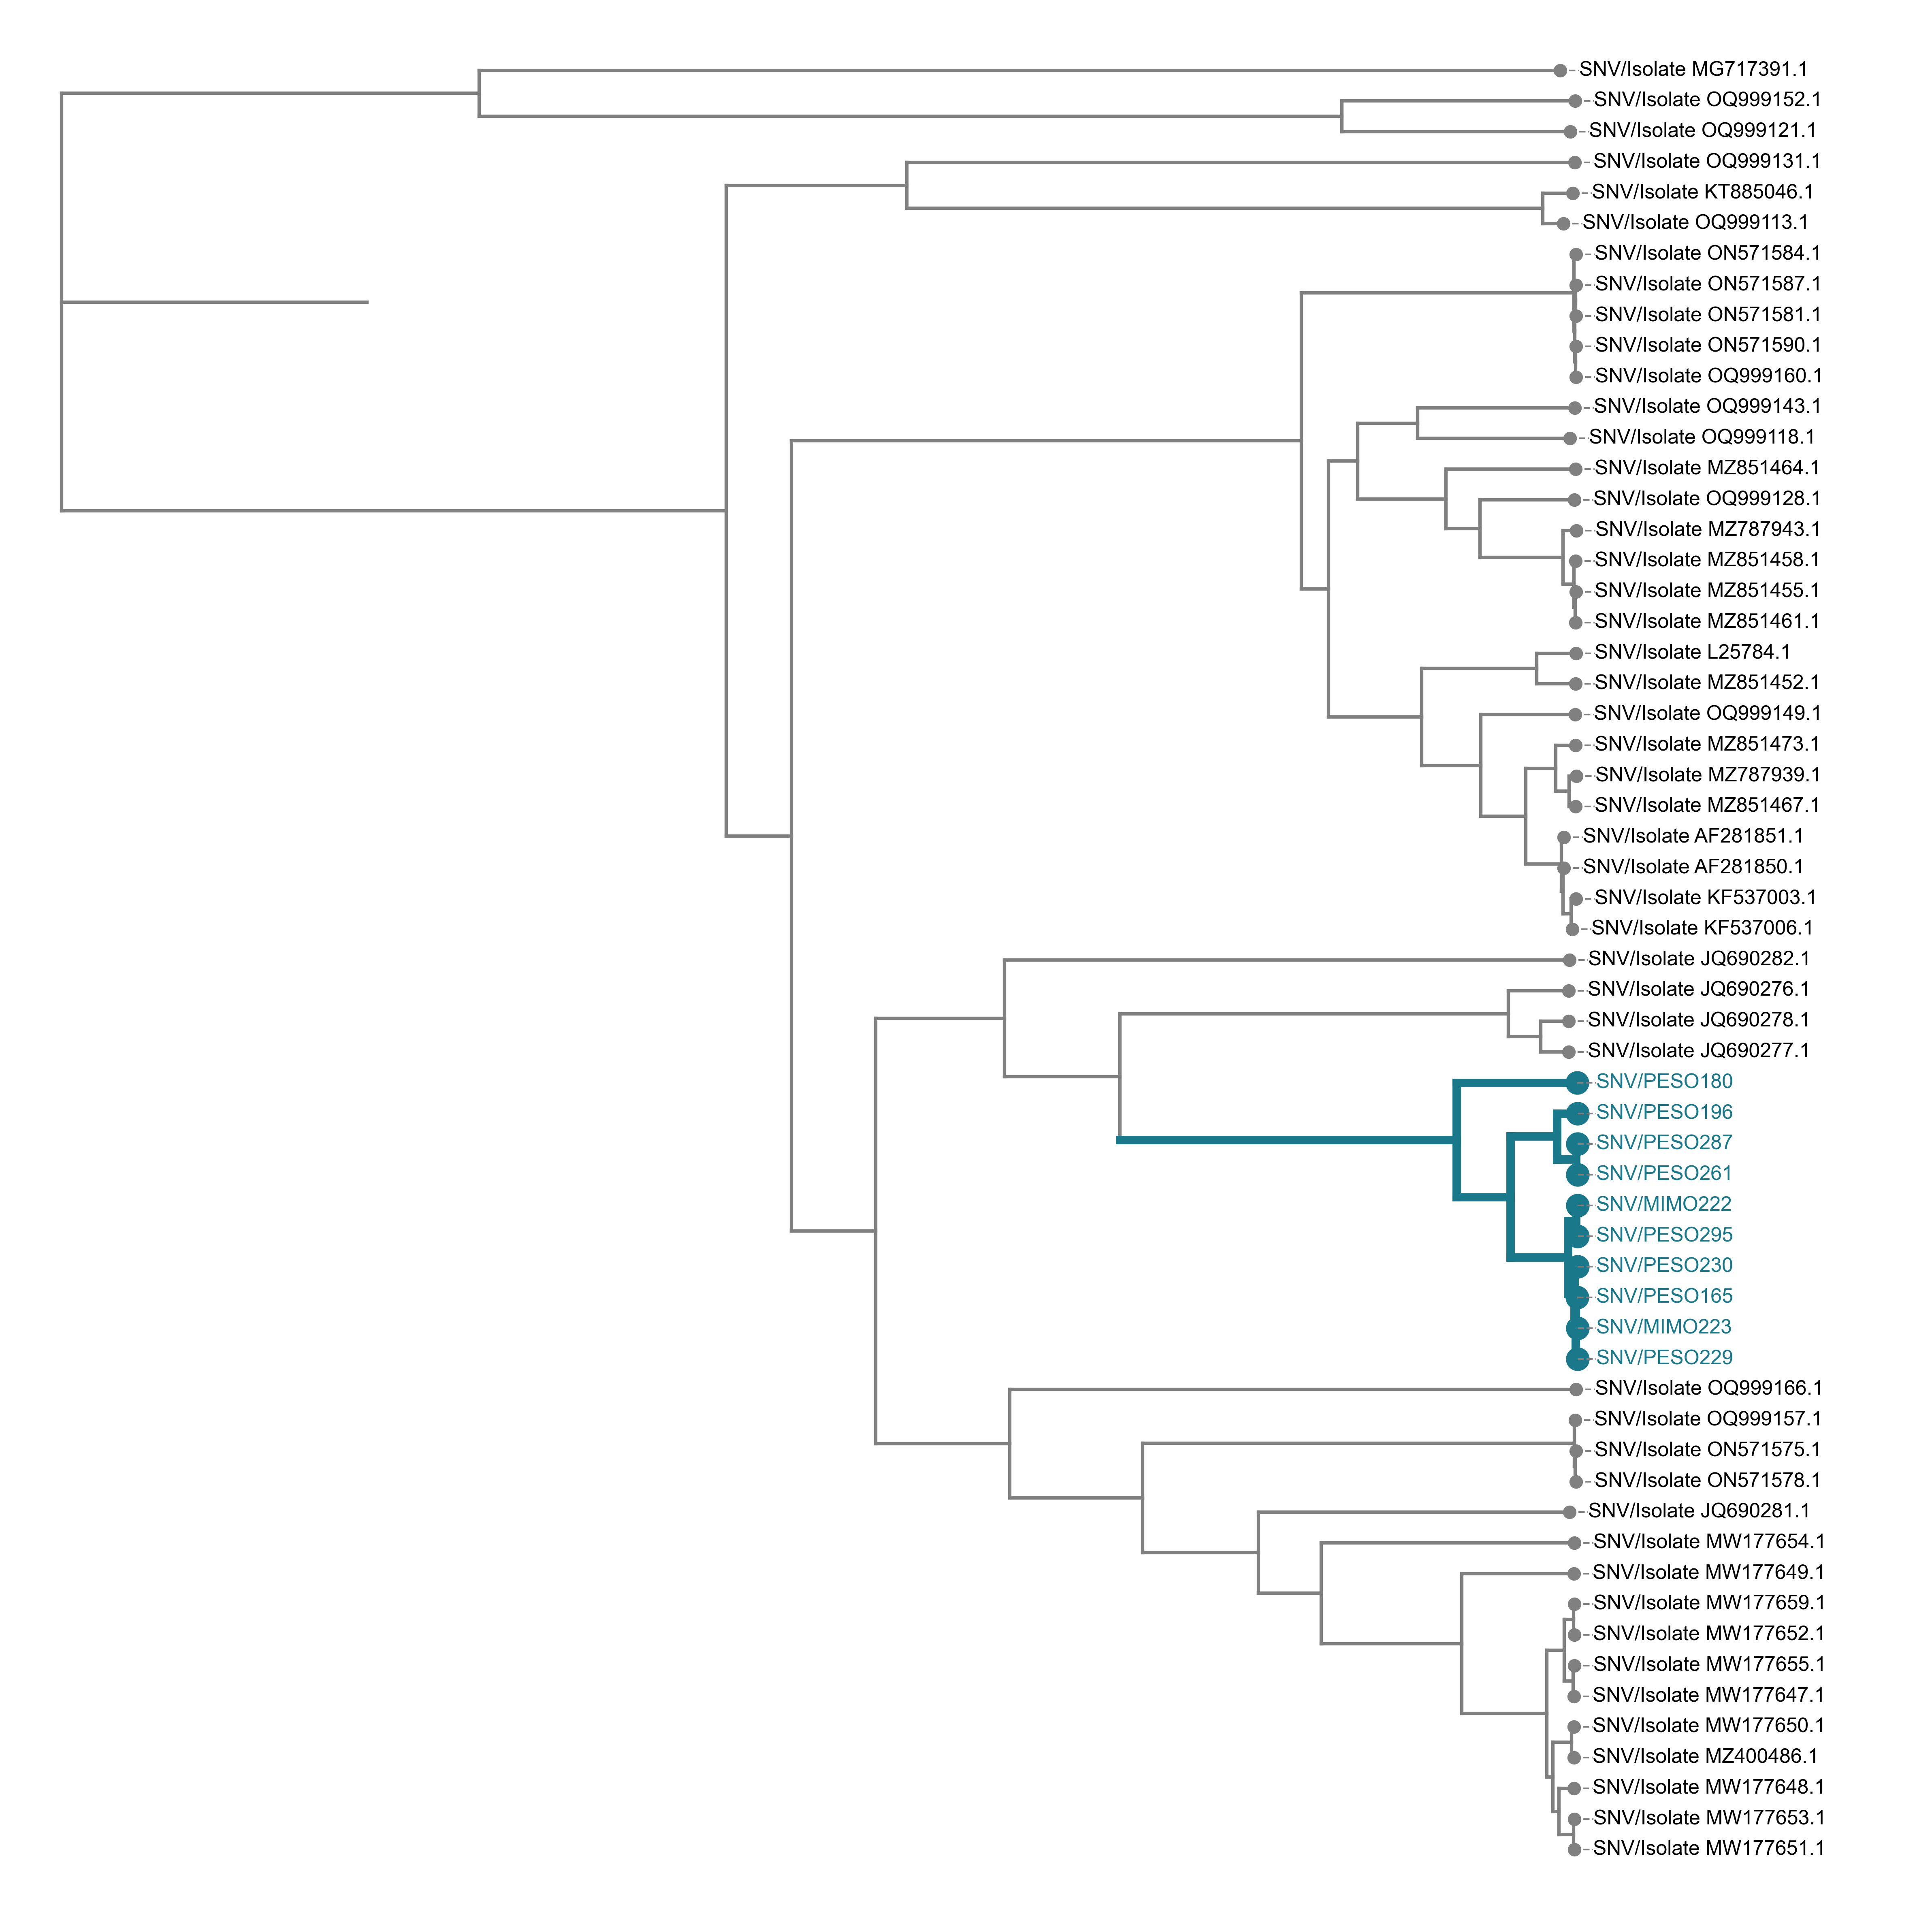

In [89]:
plotter = BalticTreePlotter('../Trees/SNV_S_NCBI_MEZAP2.aligned.mcc.tree',
                            reference_time=2025.25,
                            target_span=100, scale='linear', label_push_frac=0.01)
plotter.plot(scaled_xlim=(-9000, 2035), save="../Figures/SNVT_S.jpeg",
             dpi=600)  # or plot(x_lower=0, x_upper=1000)

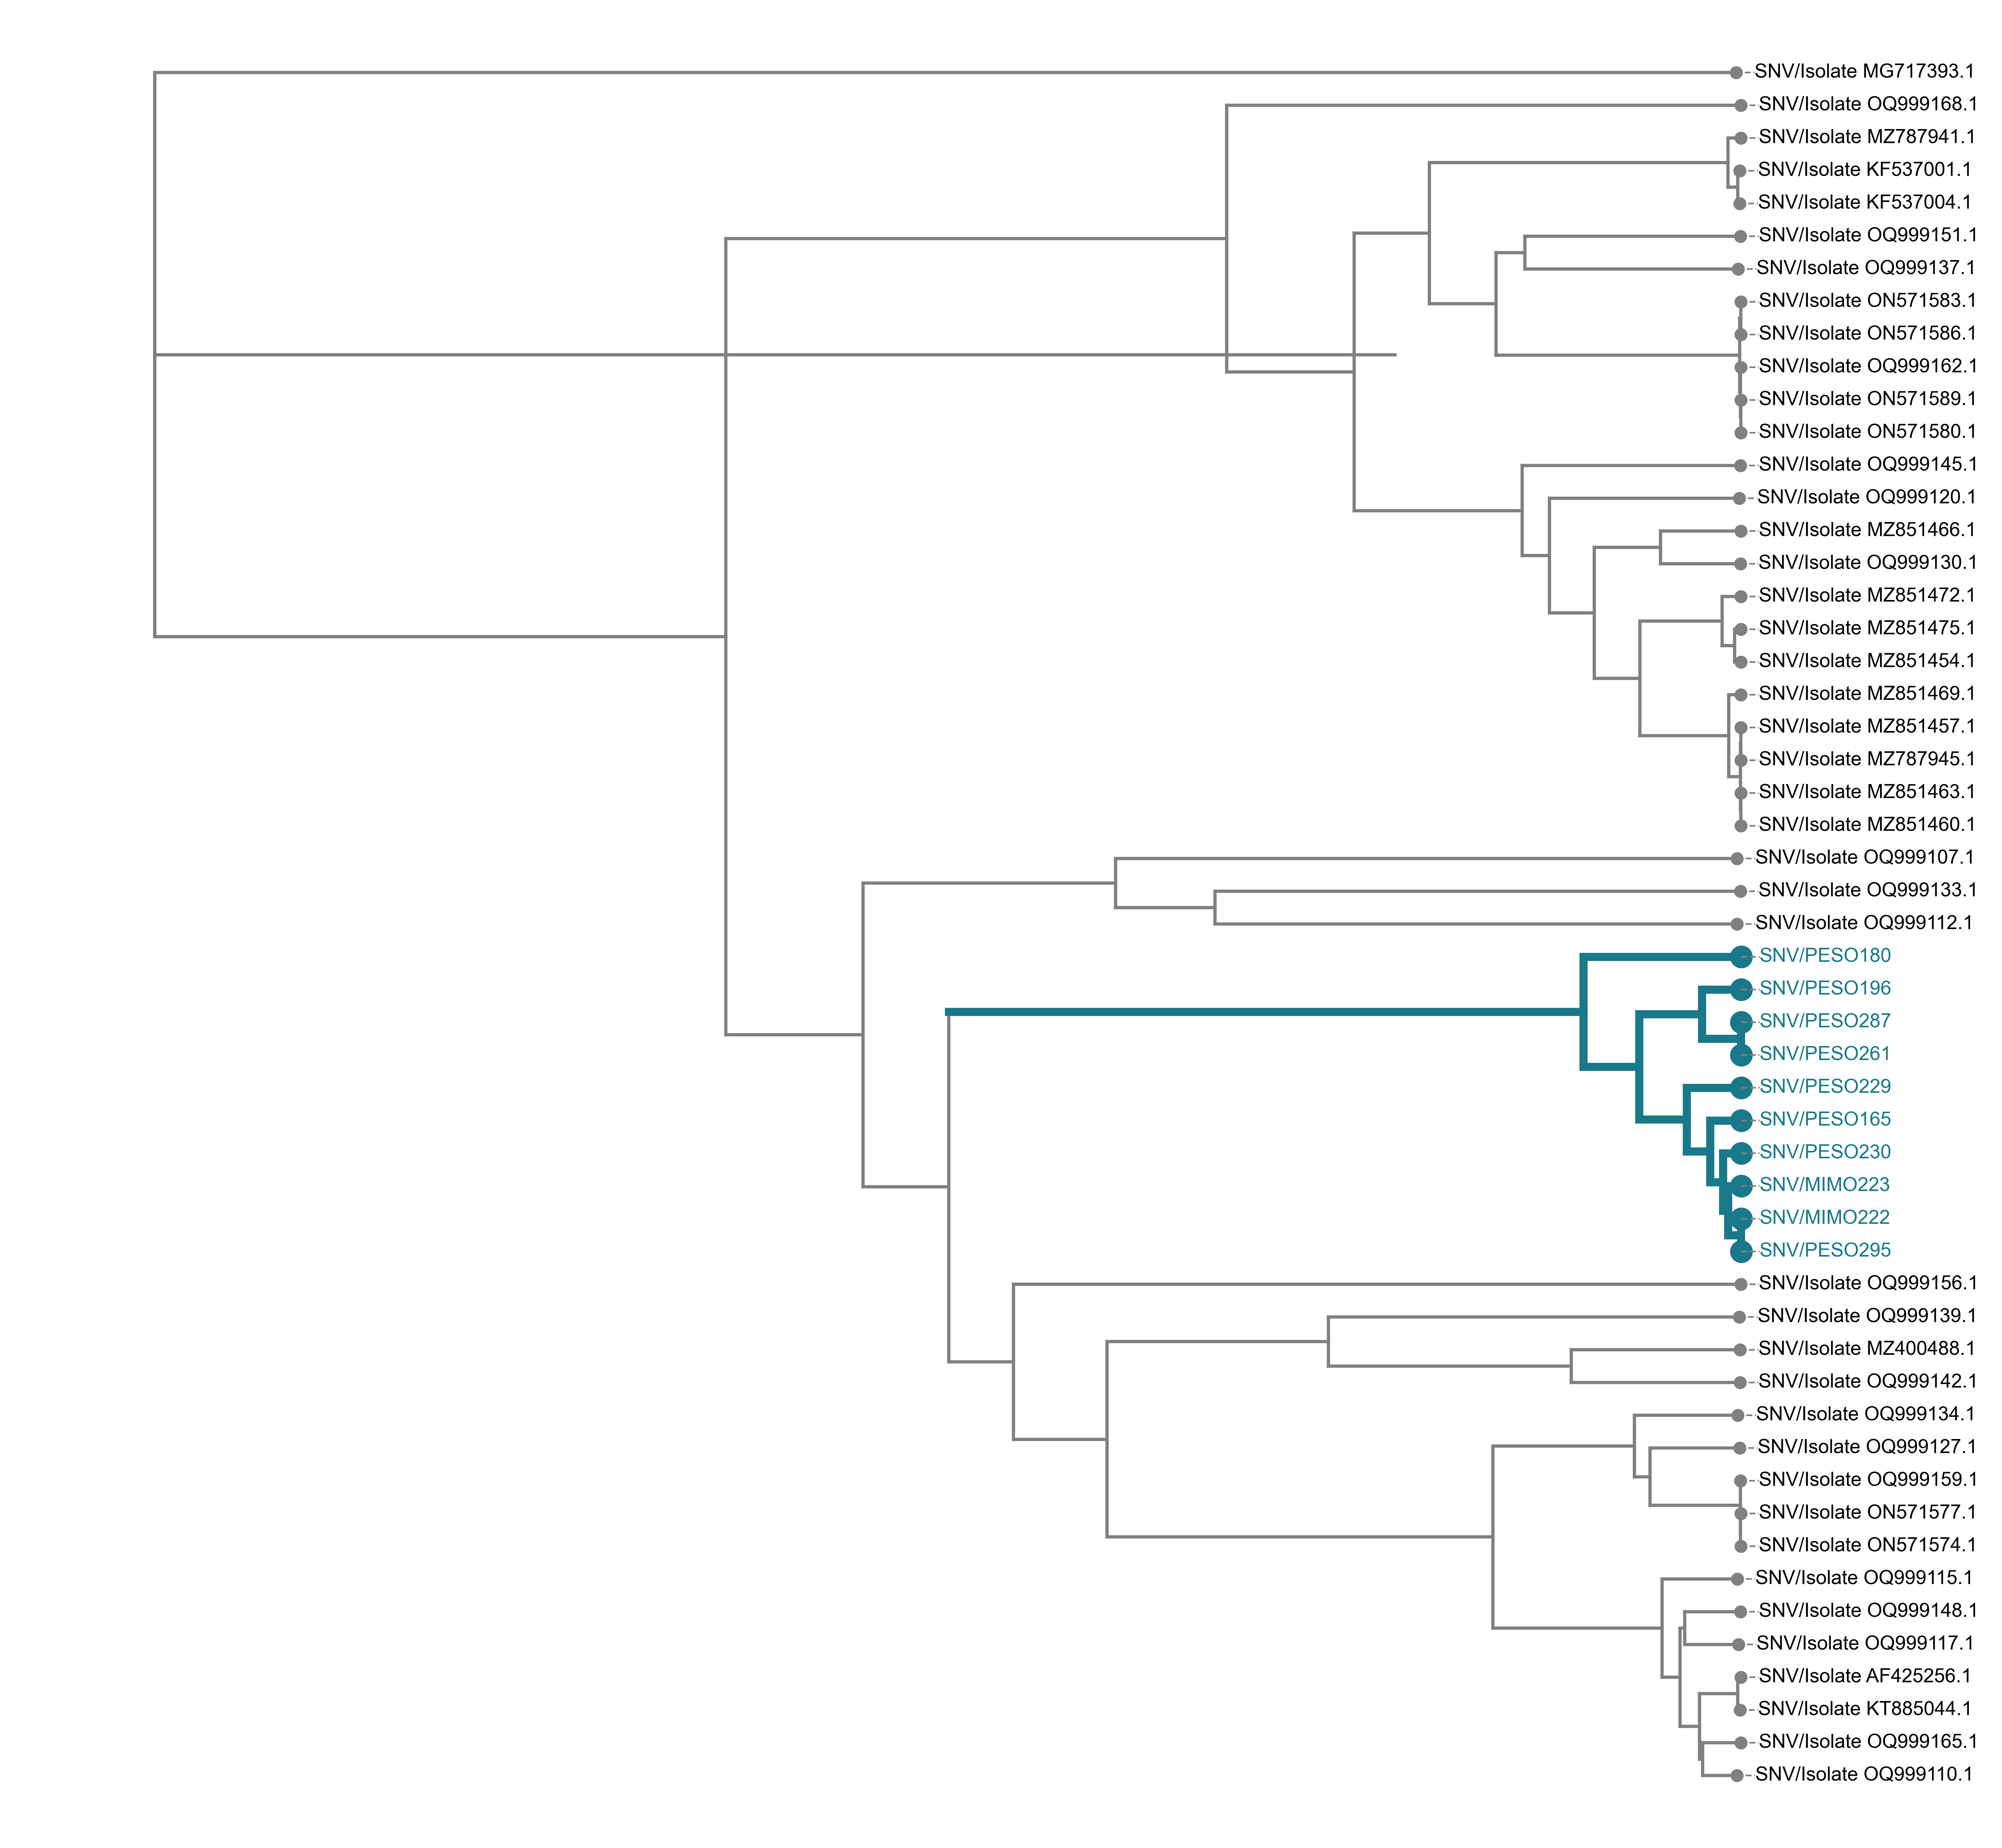

In [90]:
plotter = BalticTreePlotter('../Trees/SNV_L_NCBI_MEZAP2.aligned.mcc.tree',
                            reference_time=2025.25,
                            target_span=100, scale='linear', label_push_frac=0.01)
plotter.plot(scaled_xlim=(-35000, 2035), save="../Figures/SNVT_L.jpeg",
             dpi=600)  # or plot(x_lower=0, x_upper=1000)

In [69]:
import baltic as bt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
import numpy as np
import re


#defaults
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['font.family'] = 'Arial'


def is_snvt_like(name: str) -> bool:
    if not name: return False
    u = str(name).upper()
    if 'SNVT' in u: return True
    return re.search(r'(?:^|[^A-Z0-9])(MIPE|PESO)[-_ ]?(\d+)', u) is not None

# --- robust numeric ID extractor ---
# priority: SNVT_<PREFIX>_<NUM>  -> group(1)
#          MIPE/PESO[-_ ]?<NUM>  -> group(1)
#          WHIT<NUM>             -> group(1)
# fallback: last 3–4 digit block near end
RX_SNVT = re.compile(r'_SNVT_[A-Z]+_(\d+)', re.I)
RX_MP   = re.compile(r'(MIPE|PESO)[-_ ]?(\d+)', re.I)
RX_WHIT = re.compile(r'WHIT(\d+)', re.I)
RX_LAST = re.compile(r'(\d{3,4})(?!.*\d)')  # last 3–4 digit block

def extract_id(name: str):
    if not name: return None
    u = str(name).upper()
    m = RX_SNVT.search(u)
    if m: return m.group(1)
    m = RX_MP.search(u)
    if m: return m.group(2)
    m = RX_WHIT.search(u)
    if m: return m.group(1)
    m = RX_LAST.search(u)
    return m.group(1) if m else None

def scale_x(n, s, o):
    return (n.height * 1.2) * s + o

whit_col = "#19798b"
tree_files = {
    'S': '../Trees/SNV_S_NCBI_MEZAP2.aligned.mcc.tree',
    'M': '../Trees/SNV_M_NCBI_MEZAP2.aligned.mcc.tree',
    'L': '../Trees/SNV_L_NCBI_MEZAP2.aligned.mcc.tree'
}

# load subtrees
subtrees = {}
for seg, path in tree_files.items():
    tr = bt.loadNexus(path, absoluteTime=False)
    tr.setAbsoluteTime(2025.25)
    tips = [n for n in tr.Objects if n.is_leaf() and is_snvt_like(getattr(n,'name',''))]
    if not tips:
        print(f"[warn] no SNVT-like tips in {seg}; skipping")
        continue
    mrca = tr.commonAncestor(tips)
    st = tr.subtree(mrca, stem=False)
    rH = st.root.height
    for n in st.Objects:
        n.height -= rH
    st.setAbsoluteTime(2025.25)
    st.drawTree() 
    subtrees[seg] = st

segments = [seg for seg in ['S','M','L'] if seg in subtrees]
if not segments:
    raise RuntimeError("No segment produced a subtree; check labels/paths.")

width_per_seg = 50.0
gap = 100.0

scales, offsets = {}, {}
cum = 0.0
for seg in segments:
    H = max(n.height for n in subtrees[seg].Objects)
    scales[seg]  = width_per_seg / (H if H>0 else 1.0)
    offsets[seg] = cum
    cum += width_per_seg + gap
    segment_text = f'{seg} segment'

fig, ax = plt.subplots(figsize=(30, 10), facecolor='w')

# plot each subtree
for seg in segments:
    st  = subtrees[seg]
    scl = scales[seg]
    off = offsets[seg]

    st.plotTree(
        ax,
        colour=whit_col,
        width=3,
        x_attr=lambda n, s=scl, o=off: scale_x(n, s, o),
        y_attr=lambda n: n.y,
        zorder=2
    )
    st.plotPoints(
        ax,
        colour=whit_col,
        size=70,
        x_attr=lambda n, s=scl, o=off: scale_x(n, s, o),
        y_attr=lambda n: n.y,
        zorder=3
    )

# rightmost labels from the rightmost segment present (prefer L, then M, then S)
right_seg = next((s for s in ['L','M','S'] if s in segments), segments[-1])
label_x = offsets[right_seg] + width_per_seg * 1.5
for tip in subtrees[right_seg].Objects:
    if not tip.is_leaf(): continue
    x_tip = scale_x(tip, scales[right_seg], offsets[right_seg])
    y_tip = tip.y
    ax.plot([x_tip, label_x], [y_tip, y_tip], linestyle='--', color='gray', linewidth=0.8)
    nm = (getattr(tip,'name','') or '').upper()
    pid = extract_id(nm)
    prefix = 'PESO' if 'PEMA' in nm else ('MIMO' if 'MIPE' in nm else ('PESO' if 'PESO' in nm else 'SNV'))
    lbl = f"SNV/{prefix}-{pid}" if pid else f"SNV/{nm.split('|',1)[0]}"
    ax.text(label_x, y_tip, lbl, fontsize=16, color='k', va='center')

# connections based on numeric IDs
for i in range(len(segments)-1):
    A, B = segments[i], segments[i+1]
    sA, sB = scales[A], scales[B]
    oA, oB = offsets[A], offsets[B]
    tipsA = {}
    for n in subtrees[A].Objects:
        if n.is_leaf():
            pid = extract_id(getattr(n,'name',''))
            if pid and pid not in tipsA:
                tipsA[pid] = n
    tipsB = {}
    for n in subtrees[B].Objects:
        if n.is_leaf():
            pid = extract_id(getattr(n,'name',''))
            if pid and pid not in tipsB:
                tipsB[pid] = n

    for pid in set(tipsA) & set(tipsB):
        nA, nB = tipsA[pid], tipsB[pid]
        xA, yA = scale_x(nA, sA, oA), nA.y
        xB, yB = scale_x(nB, sB, oB), nB.y
        xm = (xA + xB) / 2.5
        ax.add_line(mlines.Line2D([xA, xm], [yA, yA], color=whit_col, lw=1, zorder=1))
        ax.add_line(mlines.Line2D([xm, xB], [yA, yB], color=whit_col, lw=1, zorder=1))

ax.set_xlim(-gap/2, cum + gap/5)
#ax.set_ylim(-1, max(n.y for st in subtrees.values() for n in st.Objects) + 2)
ax.set_ylim(-1, max(n.y for st in subtrees.values() for n in st.Objects) + 2)
ax.set_xmargin(0); ax.set_ymargin(0)

#Annotate segments
for seg in segments:
    x_center = offsets[seg] + width_per_seg/1
    ax.text(x_center, 0.06, f"{seg} segment",
            transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontsize=24, color='k', clip_on=False)

ax.axis('off')
plt.tight_layout(pad=0)
plt.savefig('../Figures/SNVT_tanglegram_tree.png', dpi=600, bbox_inches='tight')
plt.show()